In [1]:
import pandas as pd 
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import lognorm, norm
import numpy as np 
import json
import math 
from sklearn.neighbors import KernelDensity

### Case scenario - 2
Site B has Fixed sensors installed for a moth from Jan.1 to Jan 31. 2024. No flyover and ogi surveys conducted.
Also, there is no venting data. 

Site B has the same equipment on site as the Site A 

In [2]:
Equipment = ["Compressor-1","Compressor-2","Compressor-3",
            "Dehydrator-1","Tank-1","Tank-2","Separator-1","Separator-2","Separator-3",
            "Wellhead"]

In [3]:
equipment_types = ['Compressor', 'Dehydrator', 'Tank', 'Separator', 'Wellhead']

In [4]:
file_path = "Sample_site_simulated_observations_case_2.xlsx"

In [5]:
CMS = pd.read_excel(file_path, sheet_name='CMS', header=0)

In [6]:
CMS.head(2)

,id,siteId,equipmentId,startTime,endTime,rate (kg/hr)
0,CMS-1,B,Compressor-3,2024-01-01 02:16:00,2024-01-01 18:46:00,13.437431
1,CMS-2,B,Compressor-2,2024-01-01 17:12:00,2024-01-02 00:32:00,11.053783


In [7]:
cms_events = [] 
for idx,row in CMS.iterrows():
    eventType = "PRE"
    startTime = row.startTime
    endTime = row.endTime
    duration = ((endTime - startTime).total_seconds())/3600
    rate = row["rate (kg/hr)"] 
    massVolume = rate * duration 
    cms_events.append({
        "event_type":eventType, 
        "duration": duration, 
        "detection_time":startTime,
        "start_time": startTime,
        "end_time": endTime,
        "id":f"Event-{idx+1}",
        "source": row.equipmentId,
        "quantity":massVolume,
        "rate":rate,
        "equipment_type":row.equipmentId.split("-")[0],
        "duration_lower": 0, 
        "duration_upper": 2 * duration,
        "rate_lower": rate * 0.6,
        "rate_upper": rate * 0.6,
    })

In [8]:
events = pd.DataFrame(cms_events)

In [9]:
events.head()

,event_type,duration,detection_time,start_time,end_time,id,source,quantity,rate,equipment_type,duration_lower,duration_upper,rate_lower,rate_upper
0,PRE,16.500000,2024-01-01 02:16:00,2024-01-01 02:16:00,2024-01-01 18:46:00,Event-1,Compressor-3,221.717605,13.437431,Compressor,0,33.000000,8.062458,8.062458
1,PRE,7.333333,2024-01-01 17:12:00,2024-01-01 17:12:00,2024-01-02 00:32:00,Event-2,Compressor-2,81.061078,11.053783,Compressor,0,14.666667,6.632270,6.632270
2,PRE,17.600000,2024-01-02 08:38:00,2024-01-02 08:38:00,2024-01-03 02:14:00,Event-3,Tank-1,114.153335,6.485985,Tank,0,35.200000,3.891591,3.891591
3,PRE,16.583333,2024-01-03 01:20:00,2024-01-03 01:20:00,2024-01-03 17:55:00,Event-4,Dehydrator-1,161.609485,9.745296,Dehydrator,0,33.166667,5.847177,5.847177
4,PRE,3.550000,2024-01-03 23:33:00,2024-01-03 23:33:00,2024-01-04 03:06:00,Event-5,Tank-1,18.743919,5.279977,Tank,0,7.100000,3.167986,3.167986


In [10]:
events.to_csv("events_with_uncertianty_case_study_2.csv",index=False)

### Create rates and durations distribution 

In [11]:
## store rates and duration per each equipment type 
Rates = {key:[] for key in equipment_types}
Durs = {key:[] for key in equipment_types}
for sc in events["equipment_type"].unique():
    if sc != 'A':
        events_source = events[events["equipment_type"] == sc]
        for idx,row in events_source.iterrows():
            Rates[sc].append(row["rate"])
            Durs[sc].append(row["duration"])

In [12]:
## perform log-normal fitting for the rate and duration distributions 
rate_dist =  {key: [] for key in Rates.keys()}
dur_dist =  {key: [] for key in Durs.keys()} 
Sources = [] 
for key in Rates.keys():
    if len(Rates[key]) > 0: 
        data_array = np.array(Rates[key])
        cleaned_data = data_array[~np.isnan(data_array)]
        rate_dist[key] += list(lognorm.fit(cleaned_data, floc=0))
        data_array = np.array(Durs[key])
        cleaned_data = data_array[~np.isnan(data_array)]
        dur_dist[key] += list(lognorm.fit(cleaned_data, floc=0))
        Sources.append(key)

In [13]:
rate_dist

{'Compressor': [1.132203667737845, 0, 15.656832387636166],
 'Dehydrator': [0.5083399331967974, 0, 14.18556464280644],
 'Tank': [0.8540689934929071, 0, 14.84796779507835],
 'Separator': [0.7040725797646404, 0, 13.13006794826416],
 'Wellhead': [1.2824441654991403e-14, 0, 11.119572460000093]}

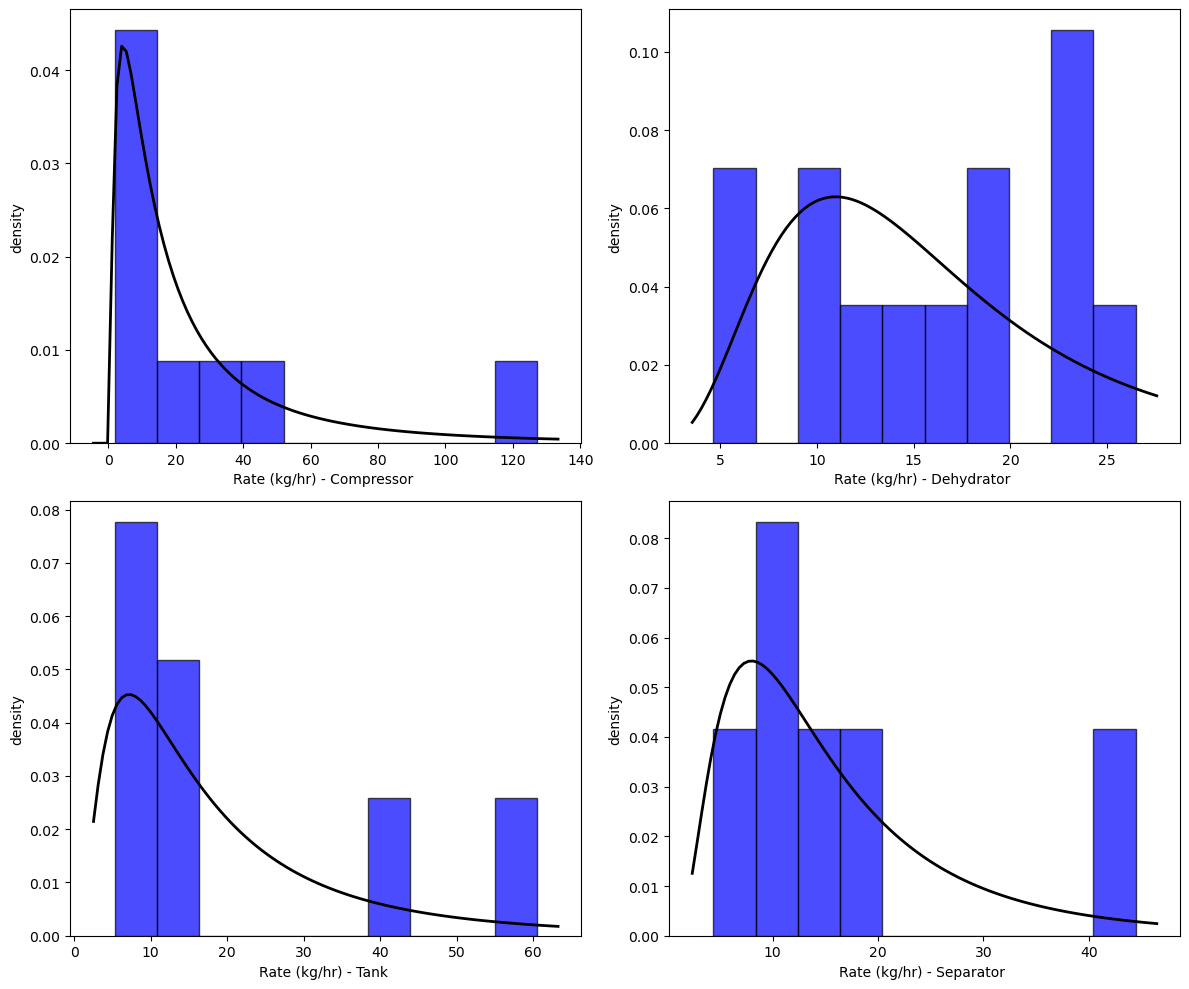

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
i = 0 
eq_types = ["Compressor", "Dehydrator", "Tank", "Separator"] 
for k in eq_types:
    ax = axs.flatten()[i]  # Flatten axs to make it a 1D array
    ax.hist(Rates[k], bins=10, alpha=0.7, color='blue', edgecolor='black', density=True)
    sour = Sources[i]
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = lognorm.pdf(x, *rate_dist[k])
    ax.plot(x, p, 'k', linewidth=2)
    ax.set_ylabel("density")
    ax.set_xlabel(f"Rate (kg/hr) - {k} ")
    #ax.set_xlim(0, 10)
    i += 1 

# Adjust layout
plt.tight_layout()
plt.show()

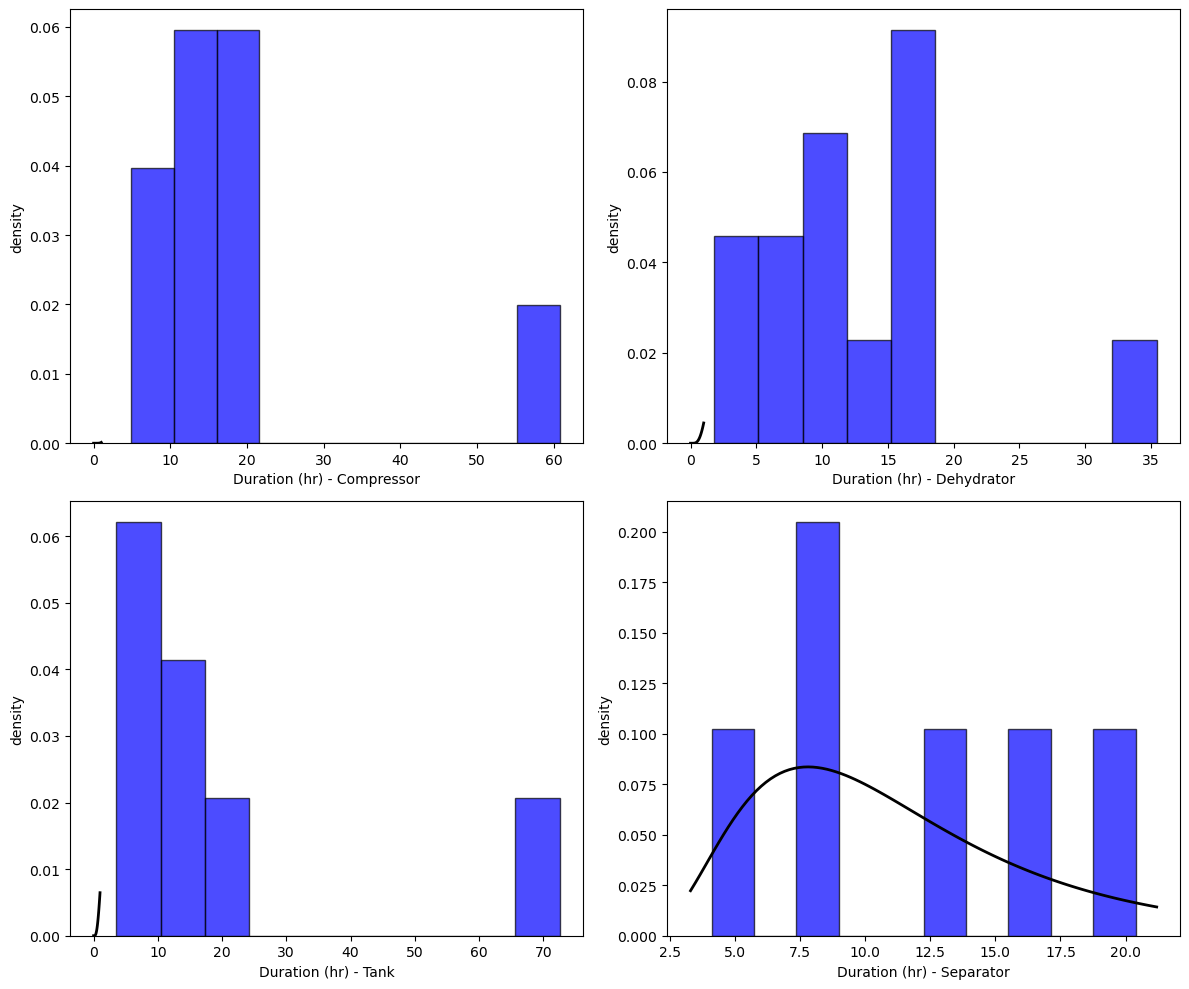

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
i = 0 
for k in eq_types:
    ax = axs.flatten()[i]  # Flatten axs to make it a 1D array
    ax.hist(Durs[k], bins=10, alpha=0.7, color='blue', edgecolor='black', density=True)
    sour = Sources[i]
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = lognorm.pdf(x, *dur_dist[k])
    ax.plot(x, p, 'k', linewidth=2)
    ax.set_ylabel("density")
    ax.set_xlabel(f"Duration (hr) - {k}")
    i += 1 

# Adjust layout
plt.tight_layout()
plt.show()

In [16]:
n_samples = 10000
rate_samples = {key: [] for key in rate_dist.keys()}
duration_samples = {key: [] for key in dur_dist.keys()}
for key in rate_dist.keys():
    if len(rate_dist[key]) > 0:
        rate_samples[key] += list(lognorm.rvs(*rate_dist[key], size=n_samples))

for key in dur_dist.keys():
    if len(dur_dist[key]) > 0:
        duration_samples[key] += list(lognorm.rvs(*dur_dist[key], size=n_samples))

### Create probability distribution 

In [17]:
def random_hex_color():
    return f"#{random.randint(0, 0xFFFFFF):06x}"
def sample_from_cdf(cdf, x_vals, n_samples=1):
    random_values = np.random.uniform(0, 1, n_samples)
    samples = np.interp(random_values, cdf, x_vals)  # Map uniform samples to x-values
    return samples

In [18]:
## total measuremnt per each equipment
equipment_counts = {"Compressor":3,
                   "Dehydrator": 1,
                   "Tank": 2,
                   "Separator": 3,
                   "Wellhead": 1}


In [19]:
Prob_dist = {key: [] for key in rate_dist.keys()}
for sa in events["equipment_type"].unique():
    if sa != "A":
        ddf = events[events["equipment_type"] == sa]
        no_emissions = [] 
        emissions = []
        for equip in ddf["source"].unique():
            sdf = ddf[ddf["source"] == equip]
            total_dur = sdf["duration"].sum()
            # Probability Of Emitting
            # in total 31 days for Janurary
            POE = total_dur/(31*24) 
            emissions.append(POE)
            # Probability of Not Emitting 
            no_emissions.append(1 - POE)
        
        Prob_dist[sa].append((np.mean(emissions),np.mean(no_emissions)))



In [20]:
Prob_dist

{'Compressor': [(0.07517174432497013, 0.9248282556750299)],
 'Dehydrator': [(0.22459677419354843, 0.7754032258064516)],
 'Tank': [(0.09240591397849462, 0.9075940860215054)],
 'Separator': [(0.03163082437275985, 0.9683691756272402)],
 'Wellhead': [(0.0257168458781362, 0.9742831541218638)]}

In [21]:
# all equipment on site 
Equipment

['Compressor-1',
 'Compressor-2',
 'Compressor-3',
 'Dehydrator-1',
 'Tank-1',
 'Tank-2',
 'Separator-1',
 'Separator-2',
 'Separator-3',
 'Wellhead']

In [23]:
final_emissions = {key: [] for key in Equipment}
mc = 0 
while mc < 10000:
    extrapolated_emissions = {key: [] for key in Equipment}
    for eq in Equipment: 
        equipment_type = eq.split("-")[0]
        eq_probs = Prob_dist.get(equipment_type)
        if len(eq_probs) > 0: 
            # start of the simulation 
            sim_datetime = datetime(2024,2,1,0,0)
            # end of the simulation 
            end_datetime = datetime(2024,5,1,0,0)
            POE = eq_probs[0][0]
            PONE = eq_probs[0][1]
            while sim_datetime < end_datetime:   
                # Sample a 1 or 0 based on the probabilities
                sample = random.choices([1, 0], weights=[POE, PONE], k=1)[0]
                if sample == 0: 
                    sim_datetime += timedelta(hours=1)
                else:
                    random_rate =random.choice(rate_samples[equipment_type])
                    random_duration = random.choice(duration_samples[equipment_type])
                    if (sim_datetime + timedelta(hours=random_duration)) > end_datetime: 
                        # truncate the duration 
                        random_duration = (end_datetime - sim_datetime).total_seconds() / 3600

                    emission = random_duration * random_rate
                    extrapolated_emissions[eq].append(emission)
                    sim_datetime += timedelta(hours=random_duration)
            
    # save data 
    for key in extrapolated_emissions.keys(): 
        final_emissions[key].append(np.sum(extrapolated_emissions[key]))
    mc +=1

In [111]:
site_level_emissions = 0 
site_level_emissions_lower_unc = []
site_level_emissions_upper_unc = []
for key in final_emissions:
    print(f"{key}:",np.median(final_emissions[key]))
    site_level_emissions += np.percentile(final_emissions[key],50) 
    site_level_emissions_lower_unc.append( np.percentile(final_emissions[key],50) - np.percentile(final_emissions[key],2.5))
    site_level_emissions_upper_unc.append(np.percentile(final_emissions[key],97.5) -  np.percentile(final_emissions[key],50))

Compressor-1: 36679.51646810195
Compressor-2: 36560.83449744762
Compressor-3: 36500.61822940252
Dehydrator-1: 27605.418235694982
Tank-1: 29713.3544192855
Tank-2: 29652.361354812354
Separator-1: 9994.35106642926
Separator-2: 10011.60463268477
Separator-3: 10007.018566378243
Wellhead: 8084.670483250708


In [112]:
site_level_emissions

234809.74795348788

In [113]:
lower_unc = 0  
for lower in site_level_emissions_lower_unc: 
    lower_unc += lower**2 
print(lower_unc**0.5)

24466.06760361826


In [114]:
upper_unc = 0  
for upper in site_level_emissions_upper_unc: 
    upper_unc += upper**2 
print(upper_unc**0.5)

43993.729061966886


In [115]:
#95% confidence interval
print(890185.1218787591,"->" ,f"[{890185.1218787591-55587.91748871652},{890185.1218787591+80007.72328332221}]")

890185.1218787591 -> [834597.2043900426,970192.8451620813]
